# Plot heatshock experiment

In [2]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter
from scipy import optimize
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

nucChannel = 0 # red emerin rings
spotChannel = 0 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

# server=True
# def macMount(path): # tansforms server path to path for izbkingston mounted on mac
#     newpath = path.replace('/mnt/','/Volumes/')
#     return newpath

path_type='wsl'

pd.set_option('display.max_columns', None)

In [3]:
def correct_path(path):
    if path_type == "server":
        return path
    if path_type == "mac":
        newpath = path.replace('/mnt/external.data/','/Volumes/external.data/')
        return newpath
    if path_type == "wsl":
        newpath = path.replace('/mnt/external.data/','/mnt/izbkingston/')
        return newpath
    
def correct_save_path(df, col_names=['raw_filepath', 'denoised_filepath']):
    if path_type == "server":
        return df
    if path_type == "mac":
        for col in col_names:
            df[col] = df[col].str.replace('/Volumes/external.data/','/mnt/external.data/')
        return df
    if path_type == "wsl":
        for col in col_names:
            df[col] = df[col].str.replace('/mnt/izbkingston/','/mnt/external.data/')
        return df

def correct_loaded_path(df, col_names=['raw_filepath', 'denoised_filepath']):
    if path_type == "server":
        return df
    if path_type == "mac":
        for col in col_names:
            df[col] = df[col].str.replace('/mnt/external.data/','/Volumes/external.data/')
        return df
    if path_type == "wsl":
        for col in col_names:
            df[col] = df[col].str.replace('/mnt/external.data/','/mnt/izbkingston/')
        return df

In [4]:
base_path = correct_path('/mnt/external.data/MeisterLab/jsemple/lhinder/segementation_Kalyan')


# if not server:
#     base_path = macMount(base_path)
df_paths =pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'2025-04-03_bet1-mSG_wPM1353')]})



# on server
#base_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
#df_paths = pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'SDC1/1273/20241108_e_hs/'),
#                                                os.path.join(base_path,'DPY27/1268/20241107_e_hs/')]})
#df_paths = pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'DPY27/1268/20241107_e_hs/')]})
#df_paths = pd.DataFrame.from_dict({'data_path': [os.path.join(base_path,'SDC1/1273/20241108_e_hs/')]})

output_path=os.path.join(base_path)

if not os.path.exists(os.path.join(output_path,"plots")):
    os.makedirs(os.path.join(output_path,"plots"))

# to choose between different ways of processing the data. individual image files will 
# get overwritten, but collected tables with have this specific suffix.
versionSuffix = 'v002'
filterNuclei = False

df=pd.DataFrame()
dist=pd.DataFrame()
file_list = pd.DataFrame()
for path in df_paths['data_path']:
    df_tmp=pd.read_csv(os.path.join(path,"nuclei_analysis_"+versionSuffix+".csv"))
    df = pd.concat([df,df_tmp])
    dist_tmp=pd.read_pickle(os.path.join(path,"dist_analysis_"+versionSuffix+".pkl"))
    dist = pd.concat([dist,dist_tmp])
    file_list_tmp = pd.read_csv(os.path.join(path,"fileList_wormMasks.csv"))
    file_list = pd.concat([file_list,file_list_tmp])

df.reset_index(drop=True,inplace=True)

dist.reset_index(drop=True,inplace=True)
correct_loaded_path(df, col_names=['raw_filepath', 'denoised_filepath'])
correct_loaded_path(dist, col_names=['raw_filepath', 'denoised_filepath'])
df.head()
dist.head()

,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_region,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,image,intensity_image,intensity_background,mask_background,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,intensity_dist_spots,intensity_dist,zproj_spots,zproj_background,anisotropy,pixelSize,spot_ACF,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,spot_ac_fittedParams,spot_ac_fittedParams_err,bg_ACF,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,bg_ac_fittedParams,bg_ac_fittedParams_err
0,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,1,4,357,976,14,404,1075,27381.0,8.492239,379.439100,1030.280158,106.719563,0.885143,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...","[[[123, 129, 127, 124, 129, 145, 129, 130, 140...","[[[True, True, True, True, True, True, True, T...",10,47,99,167.244878,164.0,24.608536,4579332,605.580041,320,83,27381,138.983132,21.108289,2661388,19149,0,"[148.82562277580072, 158.65836298932385, 168.7...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[146, 143, 135, 135, 138, 145, 148, 139, 146,...",5.0,0.043333,"[0.04339294677104281, 0.03786235027665952, 0.0...",4.285933,0.271106,0.000488,6812.846705,"[0.006110986736928459, 0.04697606958915487, 0....","[0.001005521191267111, 0.0007955547553592515, ...","[0.03033880405239391, 0.02329422248435855, 0.0...",3.731980,0.539048,0.000703,23797.166853,"[0.009177659161313282, 0.025878461430582797, 0...","[0.001065388553600733, 0.0011364765908223615, ..."
1,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,5,7,477,1151,25,551,1215,48405.0,15.623221,511.813077,1181.807644,76.840431,0.901682,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...","[[[133, 122, 125, 115, 118, 125, 144, 120, 121...","[[[True, True, True, True, True, True, True, T...",18,74,64,158.679992,156.0,21.754289,7680905,473.249108,306,74,48405,134.040035,13.870362,4938437,36843,0,"[148.51626016260164, 156.97560975609755, 161.5...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[149, 167, 141, 152, 145, 142, 147, 151, 143,...",5.0,0.043333,"[0.03793706529960523, 0.03246223920840235, 0.0...",5.682415,0.189161,0.000161,9359.432828,"[0.0014839754105420676, 0.04208213101506037, 0...","[0.0006290447387000153, 0.00047581415146390616...","[0.03235992973494848, 0.020535952010792384, 0....",2.348187,0.147460,0.000559,27248.067132,"[0.0066956880008877265, 0.04201912940452487, 0...","[0.0003545455402754514, 0.0018055874938385974,..."
2,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,8,8,629,1217,17,692,1281,15535.0,12.111941,656.911490,1247.605793,62.907712,0.736920,"[[[False, False, False, False, False, False, F...","[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...","[[[133, 144, 132, 111, 121, 137, 157, 133, 142...","[[[True, True, True, True, True, True, True, T...",9,63,64,172.793756,167.0,28.544965,2684351,814.815011,334,95,15535,145.010264,20.194719,3009398,20753,0,"[150.98340248962654, 154.60775862068965, 157.7...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[138, 144, 143, 144, 135, 137, 157, 141, 149,...",5.0,0.043333,"[0.061954990088396486, 0.04450921266249683, 0....",3.216533,0

## Add some variables
Radius might scale more linearly than volume
Coefficient of variation is independent of the mean signal

In [5]:
def coefficientOfVariation(std,mean):
    return std/mean

df['cv'] = coefficientOfVariation(df['std'],df['mean'])

df.head()


,filename,date,protein,strain,treatment,worm_id,id,raw_filepath,denoised_filepath,worm_region,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,anisotropy,pixelSize,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,cv
0,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,1,4,357,976,14,404,1075,27381.0,8.492239,379.439100,1030.280158,106.719563,0.885143,10,47,99,167.244878,164.0,24.608536,4579332,605.580041,320,83,27381,138.983132,21.108289,2661388,19149,0,5.0,0.043333,4.285933,0.271106,0.000488,6812.846705,3.731980,0.539048,0.000703,23797.166853,0.147141
1,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,5,7,477,1151,25,551,1215,48405.0,15.623221,511.813077,1181.807644,76.840431,0.901682,18,74,64,158.679992,156.0,21.754289,7680905,473.249108,306,74,48405,134.040035,13.870362,4938437,36843,0,5.0,0.043333,5.682415,0.189161,0.000161,9359.432828,2.348187,0.147460,0.000559,27248.067132,0.137095
2,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,8,8,629,1217,17,692,1281,15535.0,12.111941,656.911490,1247.605793,62.907712,0.736920,9,63,64,172.793756,167.0,28.544965,2684351,814.815011,334,95,15535,145.010264,20.194719,3009398,20753,0,5.0,0.043333,3.216533,0.325292,0.001344,4726.406084,5.398799,1.071043,0.001437,4743.474435,0.165197
3,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,22,12,357,982,16,397,1039,4819.0,13.289687,376.249844,1012.937746,56.823159,0.873007,4,40,57,172.778377,170.0,23.817950,832619,567.294731,297,115,4819,120.225994,48.315388,517092,4301,0,5.0,0.043333,4.090132,0.250232,0.000808,2620.033269,2.864535,0.071396,0.001621,305.562663,0.137853
4,wPM1353_HS_001,2025-04-03,bet1-mSG,wPM1353,HS,1,bet1-mSG_2025-04-03_wPM1353_HS_001,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,/mnt/izbkingston/MeisterLab/Kalyan/TF_strains/...,tailnuc,26,15,369,1045,16,399,1075,695.0,15.000000,382.402878,1059.435971,34.983013,inf,1,30,30,167.694964,164.0,24.697809,116548,609.981773,250,113,695,140.463415,14.661543,28795,205,0,5.0,0.043333,4.080324,0.466536,0.002097,1391.757795,1.646530,0.072869,0.003242,2536.987964,0.147278


## Functions for plotting table metrics

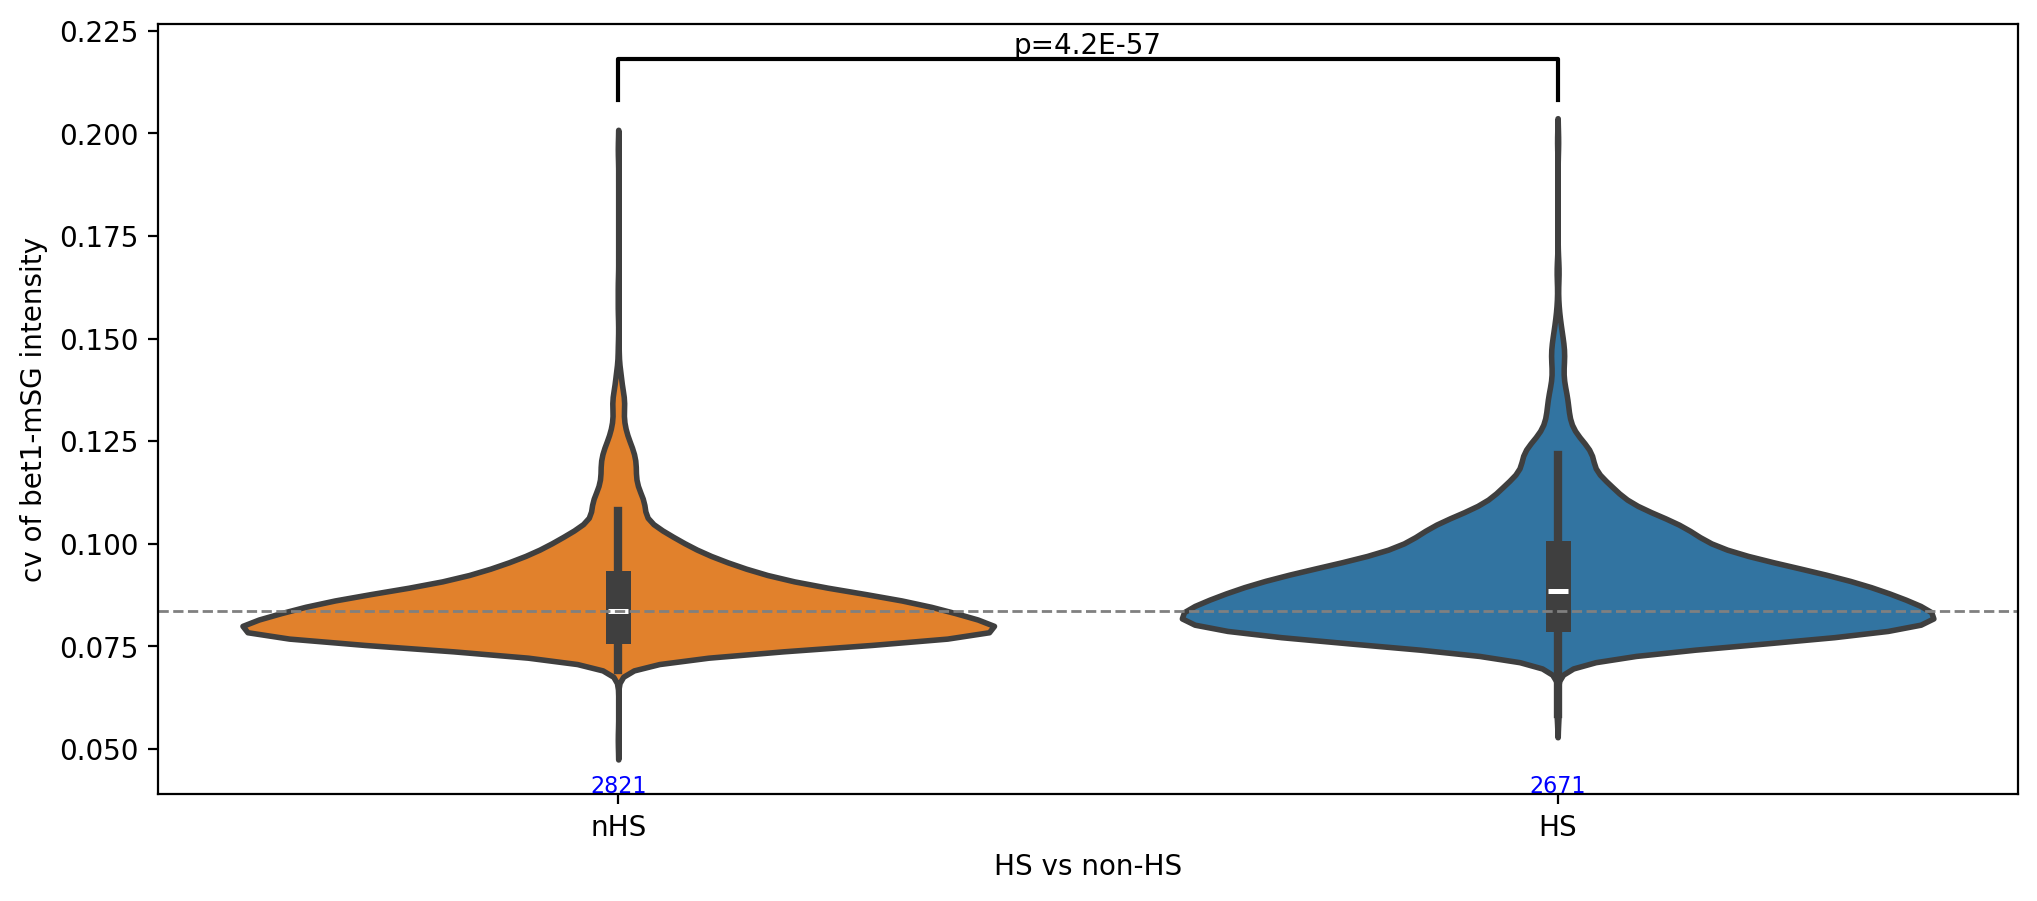

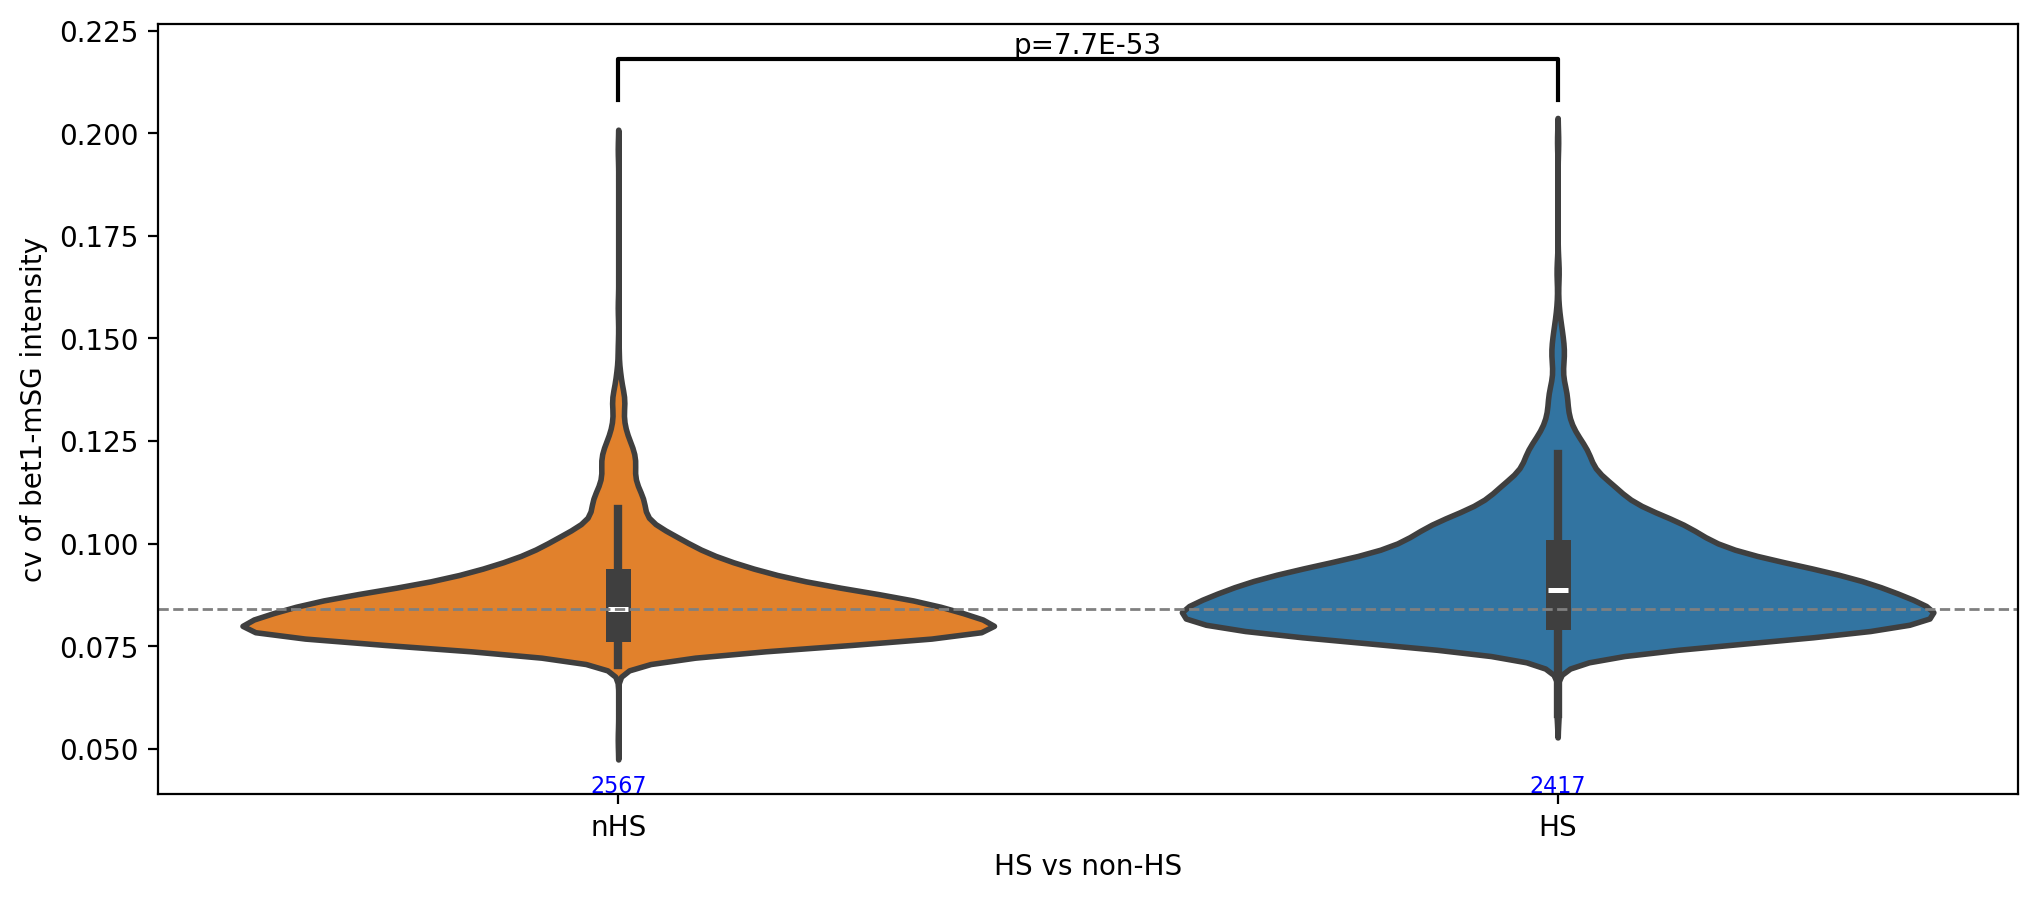

In [6]:
def format_p_value(pvalue):
    if pvalue < 0.001:
        return "{:.1E}".format(pvalue)
    else:
        return f"{pvalue:.3f}"


def plot_violin(df,file_list,output_path, metric='cv'):
    p = df.protein.unique()[0]
    plt.figure(figsize = (12,5),dpi = 200)
    order= ['nHS', 'HS']
    ax=sns.violinplot(data=df, y=metric, x="treatment",hue="treatment", order=order, linewidth=2)
    
    res = mannwhitneyu(x=df[metric][df['treatment'] == "HS"], y=df[metric][df['treatment'] == "nHS"])
    # statistical annotation
    x1, x2 = 0, 1   
    y, h, col = df['cv'].max() + 0.01, 0.01, 'k'

    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "p="+format_p_value(res.pvalue), ha='center', va='bottom', color=col)

    plt.xlabel("HS vs non-HS")
    plt.ylabel(metric+" of "+p+" intensity")

    # add horizontal line for t=0
    nHS_median = df[df['treatment'] == "nHS"][metric].median()
    plt.axhline(y=nHS_median, color='grey', linestyle='--', linewidth=1)

   # get number of nuclei at each timepoint
    num_nuclei = df.groupby(['treatment'])[metric].count().reset_index(name='num_nuclei')
    ylims = plt.gca().get_ylim()
    ypos=ylims[0]+0.01*np.abs(ylims[0])
    for n in range(len(num_nuclei)):
        plt.text(x=num_nuclei.treatment.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')
    plt.show()


plot_violin(df,file_list,output_path, metric='cv')

df_subset = df[(df['solidity'] != np.inf)]
plot_violin(df_subset,file_list,output_path, metric='cv')

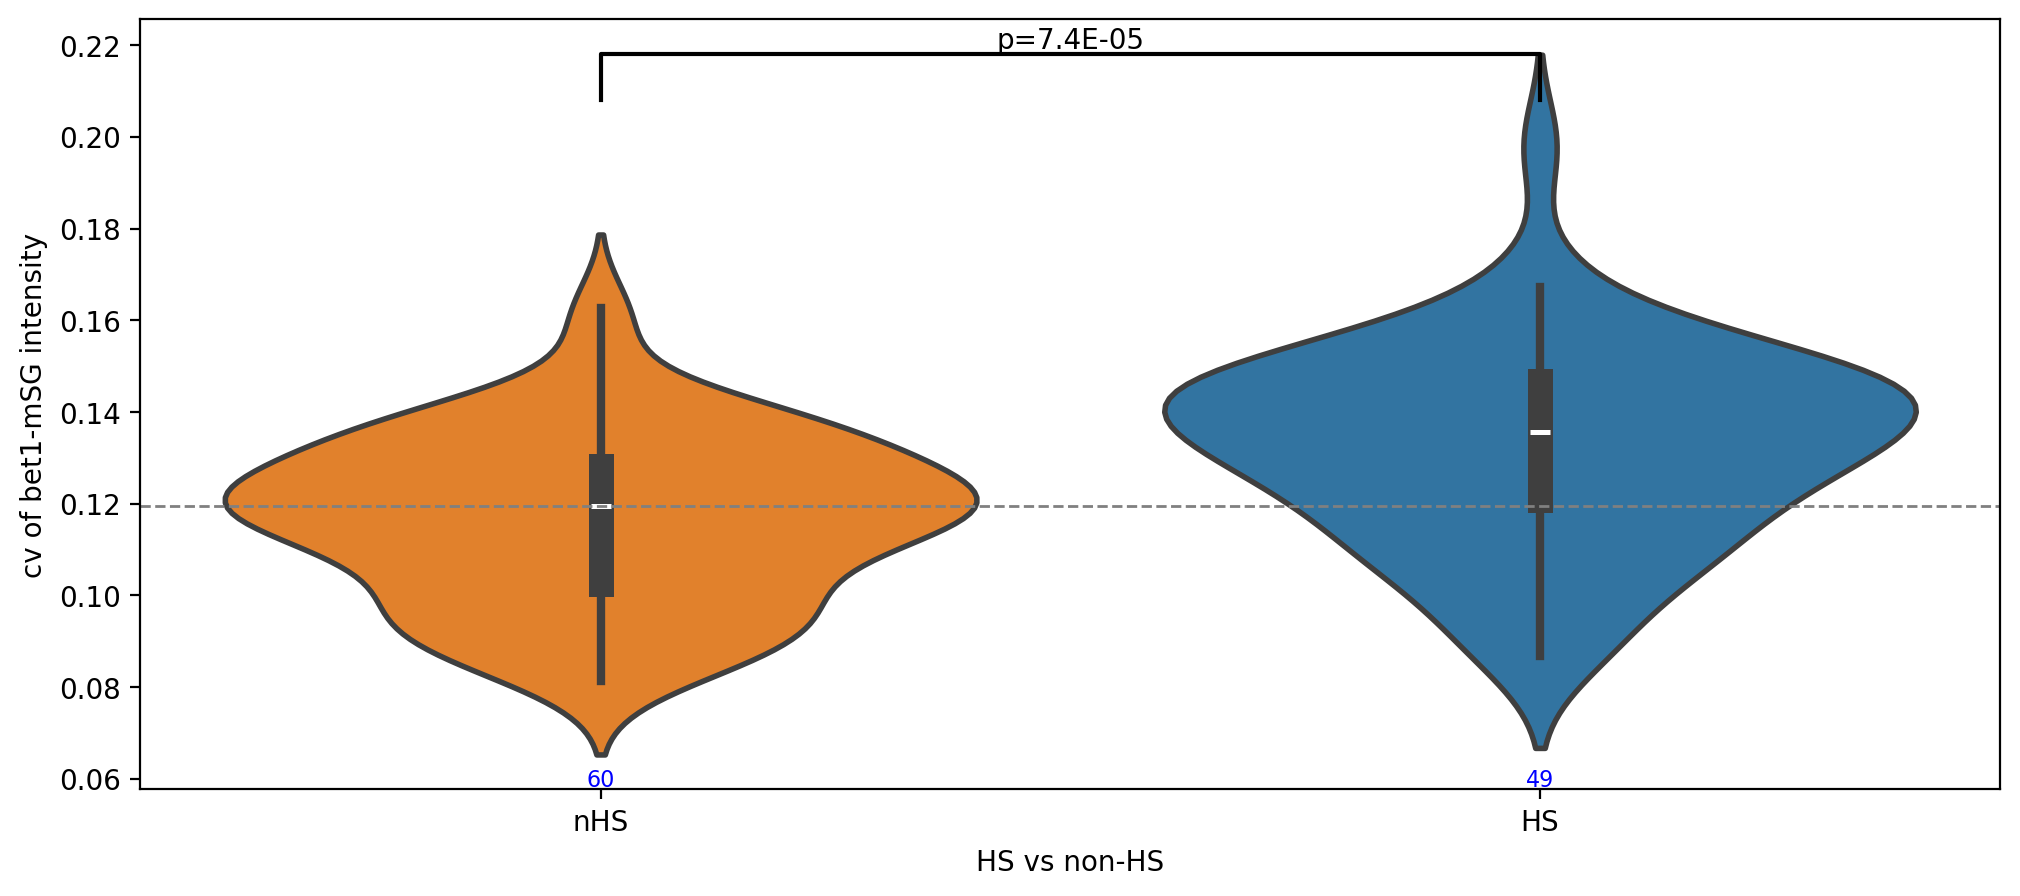

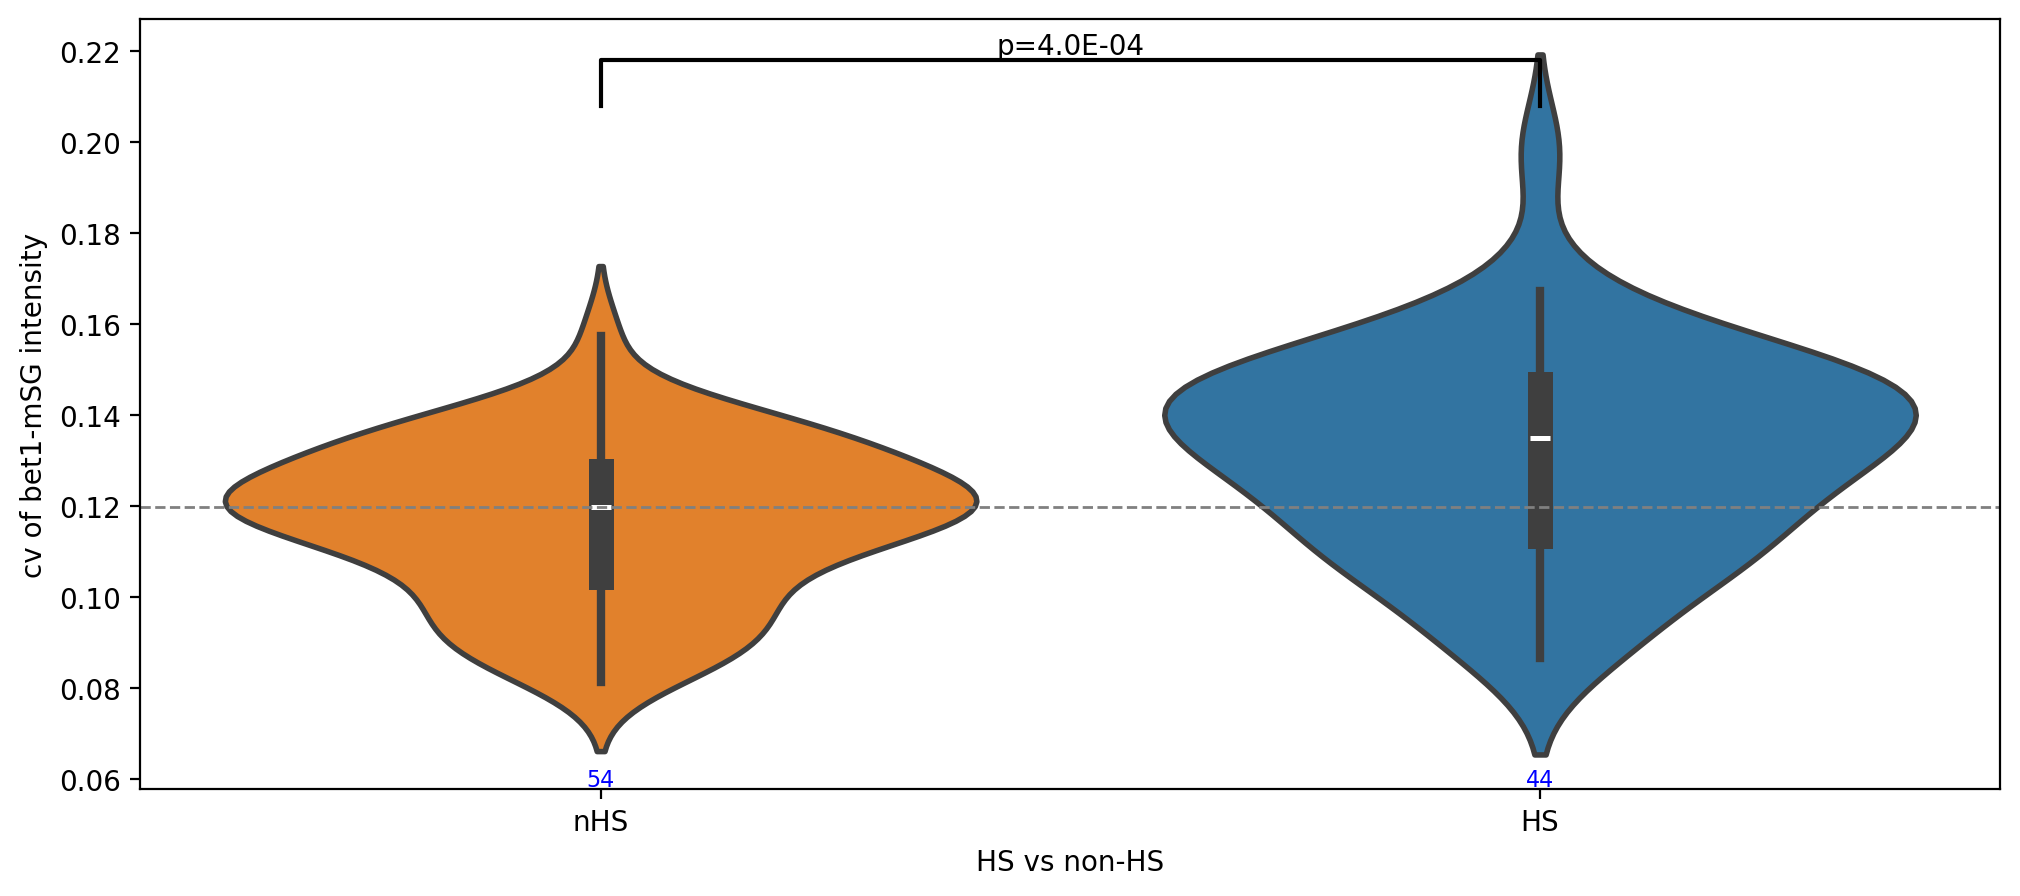

In [7]:
df_subset = df[(df['worm_region'] == "tailnuc")]
plot_violin(df_subset,file_list,output_path, metric='cv')

df_subset = df[(df['worm_region'] == "tailnuc") & (df['solidity'] != np.inf) ]
plot_violin(df_subset,file_list,output_path, metric='cv')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_001'),
  Text(1, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_002'),
  Text(2, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_003'),
  Text(3, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_004'),
  Text(4, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_005'),
  Text(5, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_006'),
  Text(6, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_007'),
  Text(7, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_008'),
  Text(8, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_009'),
  Text(9, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_010'),
  Text(10, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_011'),
  Text(11, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_012'),
  Text(12, 0, 'bet1-mSG_2025-04-03_wPM1353_HS_013'),
  Text(13, 0, 'bet1-mSG_2025-0

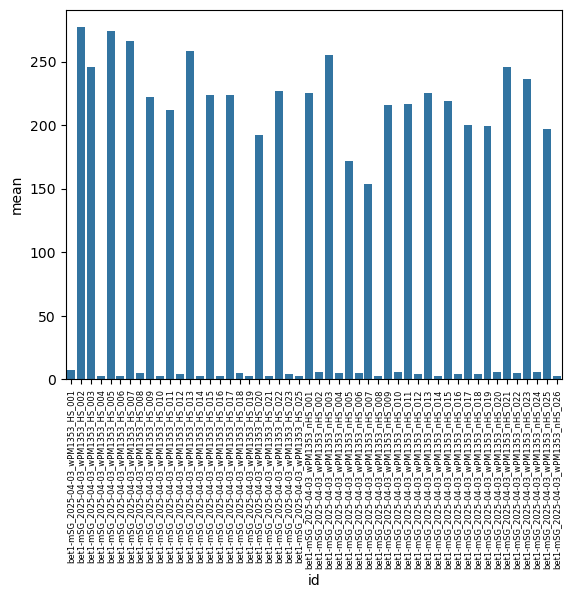

In [8]:
nucCounts=df.groupby(['id']).count()
sns.barplot(data=nucCounts, x='id', y='mean', linewidth=2)
plt.xticks(rotation=90,size=6)


In [9]:
nucCounts

,filename,date,protein,strain,treatment,worm_id,raw_filepath,denoised_filepath,worm_region,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,area,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,bb_dimZ,bb_dimY,bb_dimX,mean,median,std,sum,variance,max,min,volume,mean_background,std_background,sum_background,volume_background,timepoint,anisotropy,pixelSize,spot_ac_length,spot_ac_error,spot_ac_rmse,spot_ac_conditionNumber,bg_ac_length,bg_ac_error,bg_ac_rmse,bg_ac_conditionNumber,cv
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bet1-mSG_2025-04-03_wPM1353_HS_001,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
bet1-mSG_2025-04-03_wPM1353_HS_002,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277
bet1-mSG_2025-04-03_wPM1353_HS_003,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246,246
bet1-mSG_2025-04-03_wPM1353_HS_004,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
bet1-mSG_2025-04-03_wPM1353_HS_005,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274,274
bet1-mSG_2025-04-03_wPM1353_HS_006,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
bet1-mSG_2025-04-03_wPM1353_HS_007,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266
bet1-mSG_2025-04-03_wPM1353_HS_008,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
bet1-mSG_2025-04-03_wPM1353_HS_009,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222


In [6]:
def plot_violin(df,file_list,time_interval,output_path, metric='cv'):
    p = df.protein.unique()[0]
        df_subset = df[df['id'] == i]
        plt.figure(figsize = (12,5),dpi = 200)
        sns.violinplot(data=df_subset, y=metric, x="treatment",color="treatment", inner=None)
        plt.xlabel("HS vs non-HS")
        plt.ylabel(metric+" of mSG::"+p+" intensity")
        

        # add horizontal line for t=0
        t0_mean = df_subset[df_subset['time'] == 0][metric].median()
        plt.axhline(y=t0_mean, color='grey', linestyle='--', linewidth=0.5)
        
        # add median points
        medians_df = df_subset.groupby(['timepoint','time'])[metric].median().reset_index(name='Median')
        plt.scatter(x=medians_df.timepoint, y=medians_df.Median, color='black', s=10)

        # get number of nuclei at each timepoint
        num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
        ylims = plt.gca().get_ylim()
        ypos=ylims[0]+0.01*np.abs(ylims[0])
        for n in range(len(num_nuclei)):
            plt.text(x=num_nuclei.timepoint.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')


        plt.title(p+'::mSG signal upon heatshock') 
        plt.savefig(os.path.join(output_path,"plots",i+"_"+metric+"_"+str(np.where(filterNuclei, "filtNuclei", "allNuclei"))+".png"))

        plt.show()




def plot_mean_se_hs(df,file_list,time_interval,output_path, metric='cv'):
    ids = df.id.unique()
    p = df.protein.unique()[0]
    for i in ids:
        df_subset = df[df['id'] == i]
        meanVals = df_subset[(df_subset.protein==p)].groupby(['timepoint','time'])[metric].mean().reset_index(name='mean')
        stdVals = df_subset[(df_subset.protein==p)].groupby(['timepoint','time'])[metric].std().reset_index(name='std')
        numNuc = df_subset[(df_subset.protein==p)].groupby(['timepoint','time'])[metric].count().reset_index(name='numNuc')
        meanVals = pd.merge(meanVals, stdVals, on=['timepoint','time'])

        plt.figure(figsize = (12,5),dpi = 200)
        plt.errorbar(
            x=meanVals['time'],
            y=meanVals['mean'],
            yerr=meanVals['std'],
            fmt='o',
            color="black",
            alpha=0.8,
            capsize=3)
        plt.xlabel("Time (min)")
        plt.ylabel(metric+" of mSG::"+p+" intensity")

        # add box for heatshock
        plt.hlines(y= plt.gca().get_ylim()[1]*0.98, xmin=1*time_interval, xmax=7*time_interval, color='red', linewidth=2)
        plt.text(x=3*time_interval, y=plt.gca().get_ylim()[1]*0.98, s='37$^\circ$C', color='red', ha='center')
        plt.axvspan(1*time_interval, 7*time_interval, color='pink', alpha=0.3)

        # add horizontal line for t=0
        t0_mean = df_subset[df_subset['time'] == 0][metric].mean()
        plt.axhline(y=t0_mean, color='grey', linestyle='--', linewidth=0.5)

        # get number of nuclei at each timepoint
        num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
        ylims = plt.gca().get_ylim()
        ypos=ylims[0]+0.01*np.abs(ylims[0])
        for n in range(len(num_nuclei)):
            plt.text(x=num_nuclei.time.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')


        plt.title(p+'::mSG signal upon heatshock') 
        plt.savefig(os.path.join(output_path,"plots","mean_se_"+i+"_"+metric+"_"+str(np.where(filterNuclei, "filtNuclei", "allNuclei"))+".png"))

        plt.show()

IndentationError: unexpected indent (2258292265.py, line 3)

# Plot by protein

### Plots of coefficient of variation

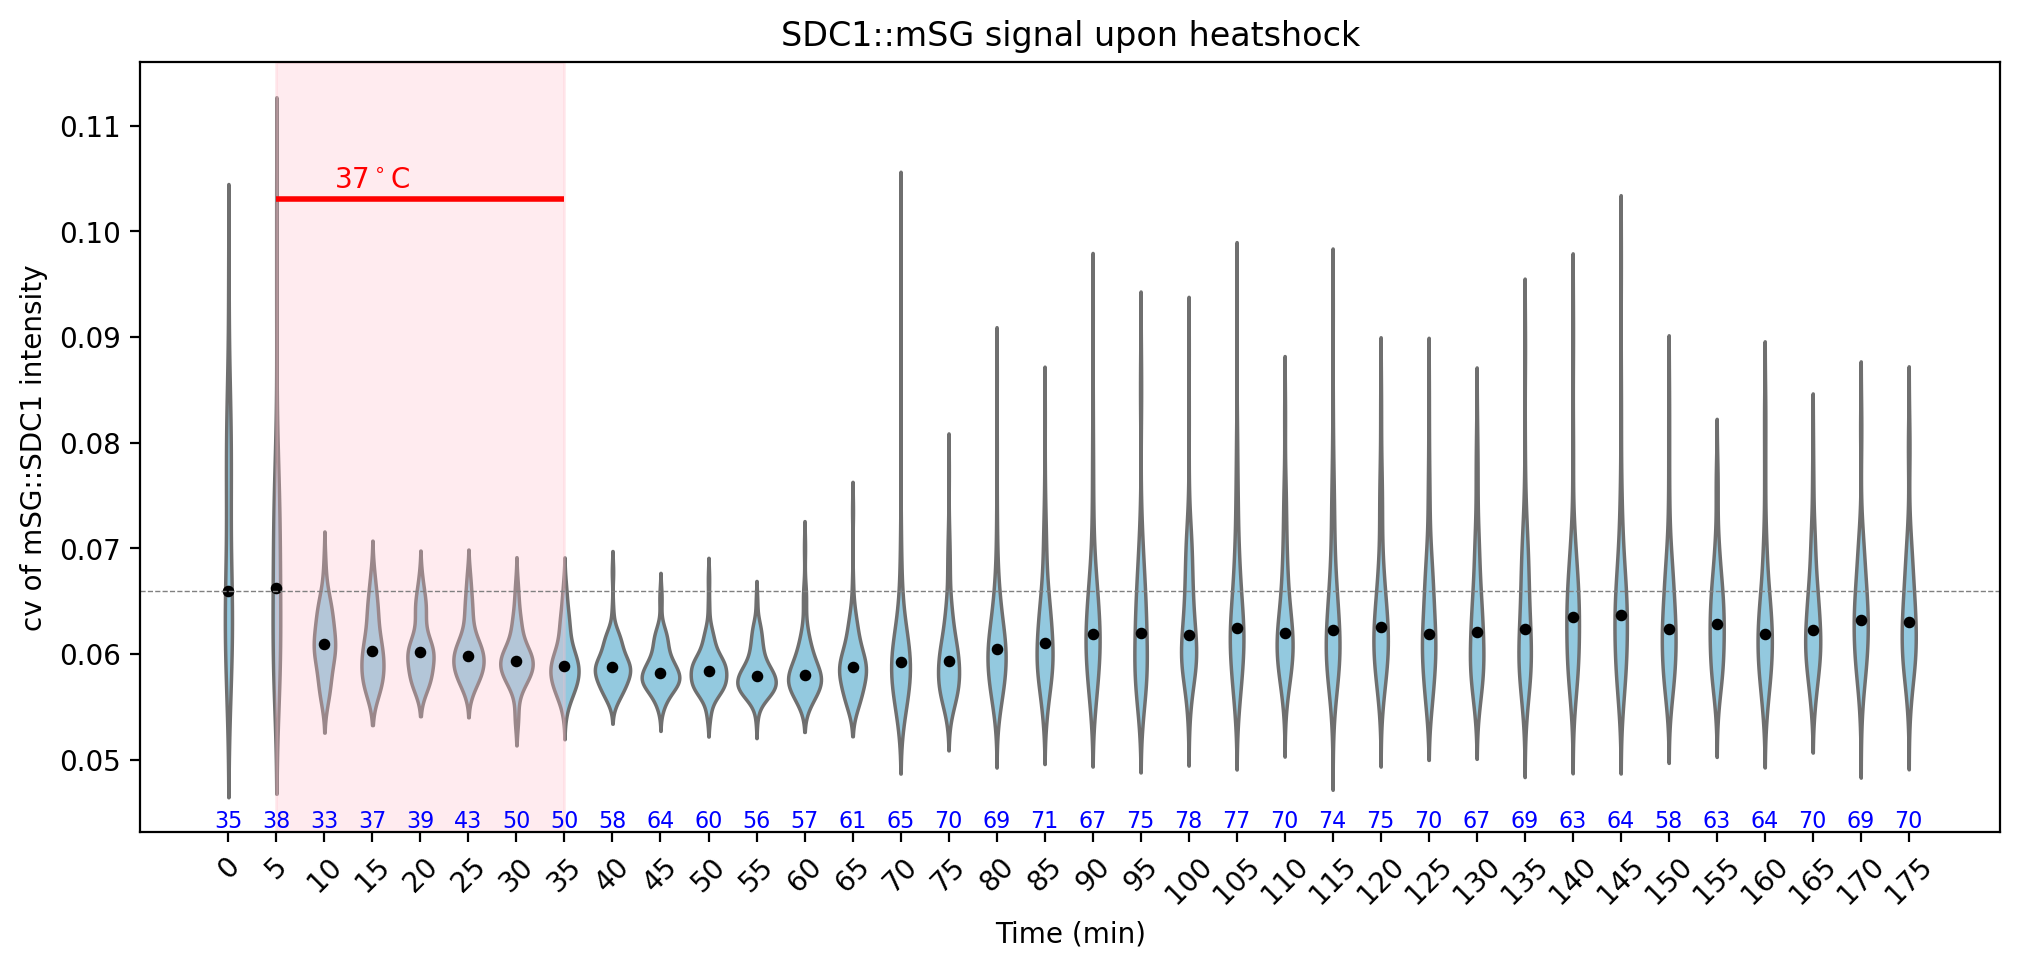

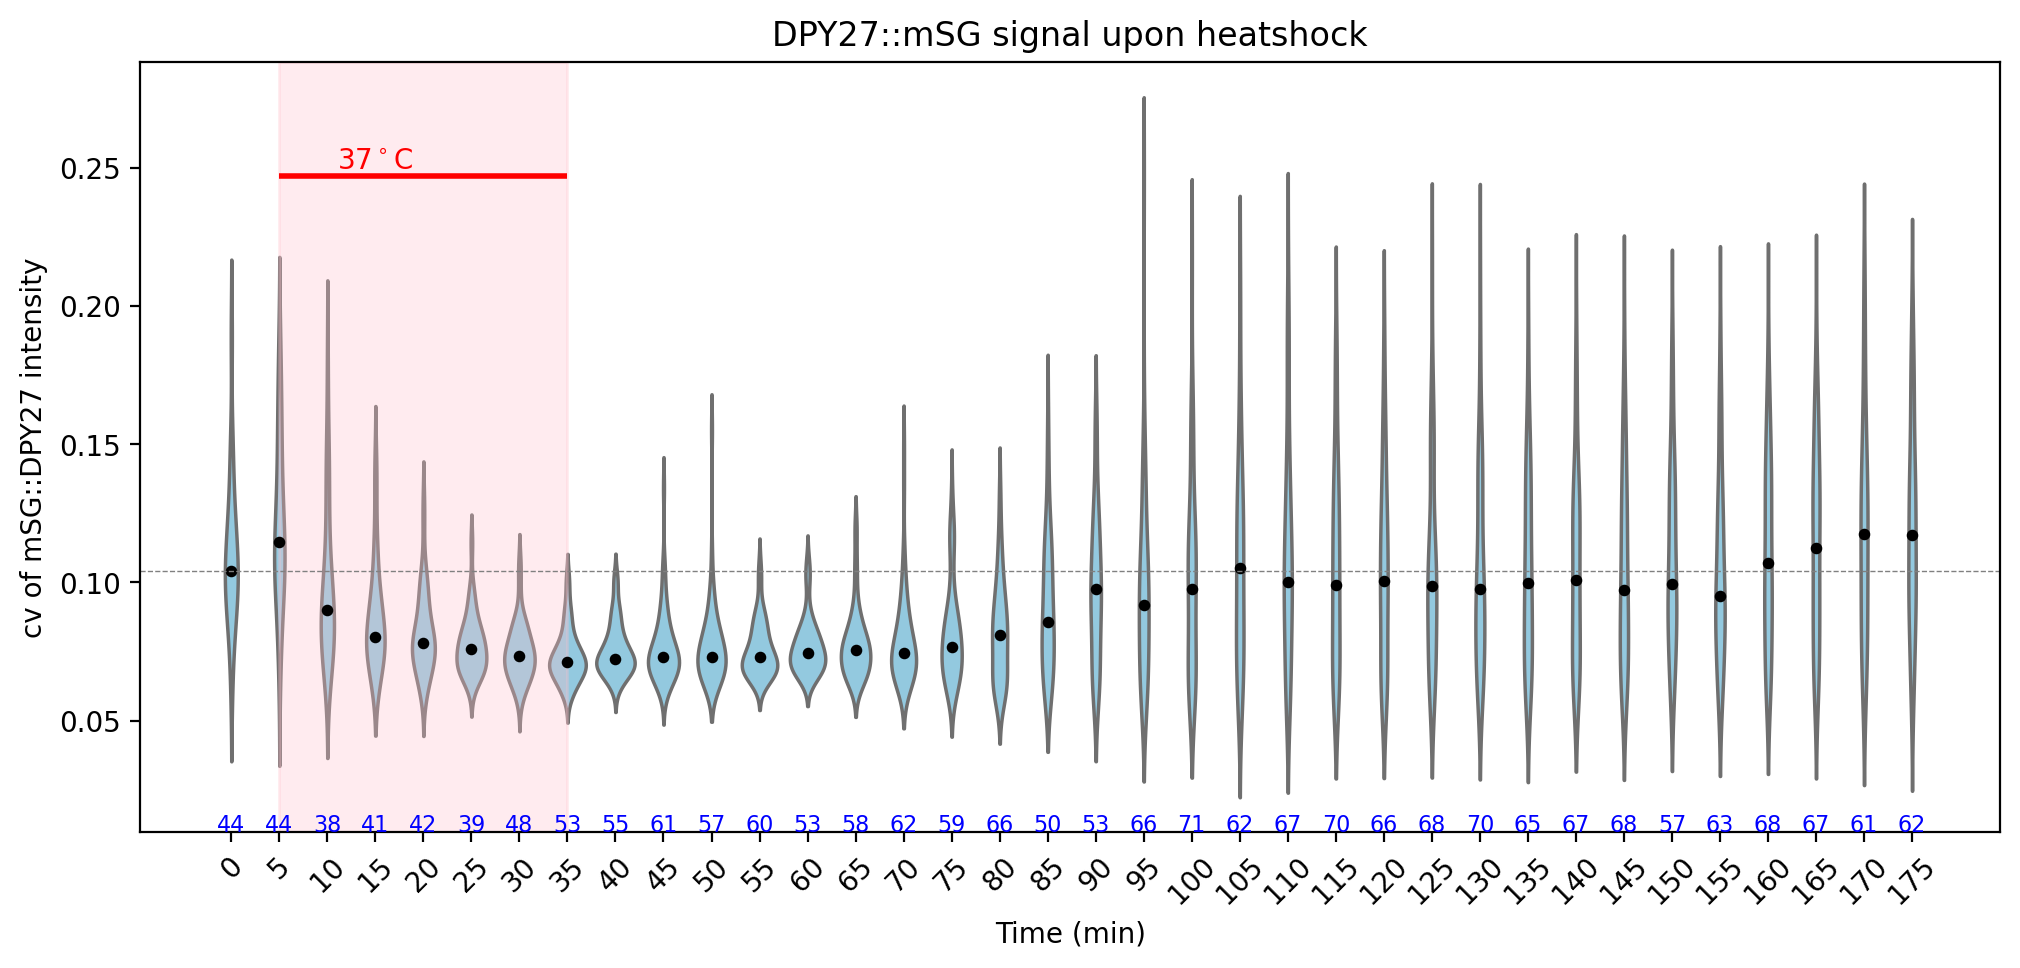

In [85]:
proteins = df.protein.unique()

for p in proteins:
    df_protein = df[df['protein'] == p]
    plot_violin_hs(df_protein,file_list,time_interval,output_path, metric='cv')



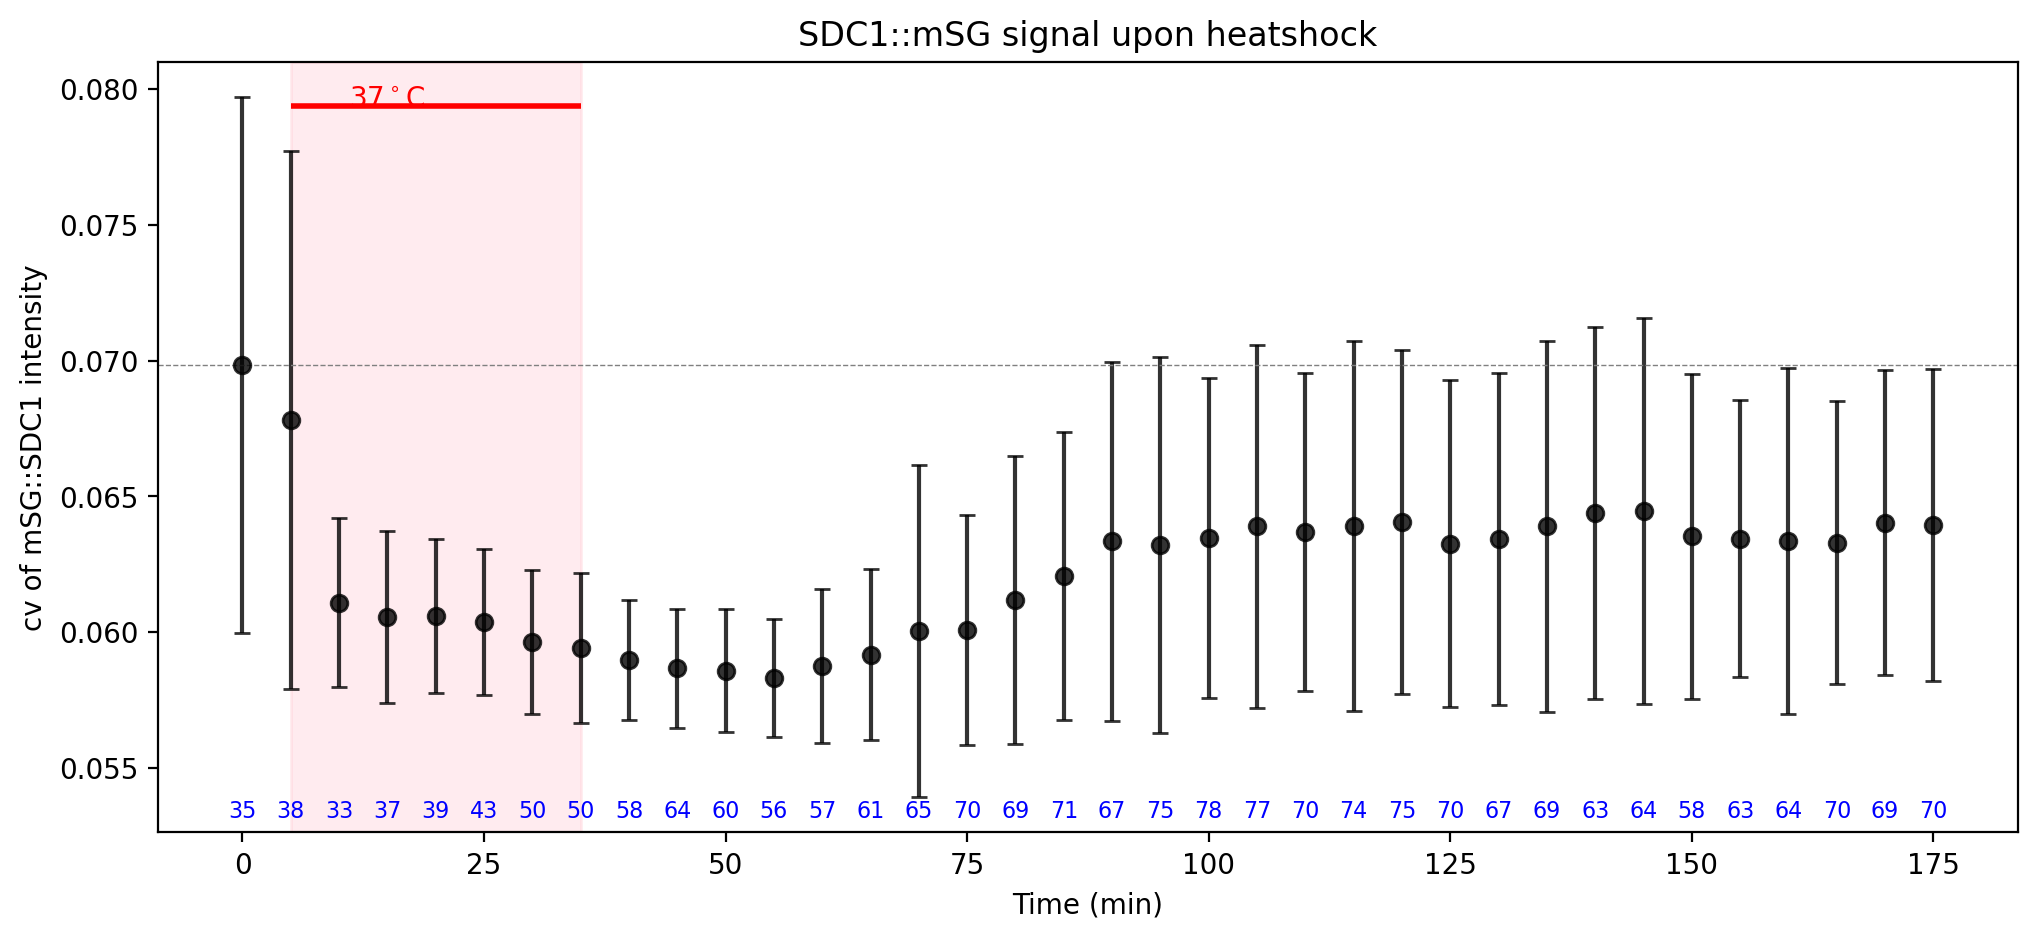

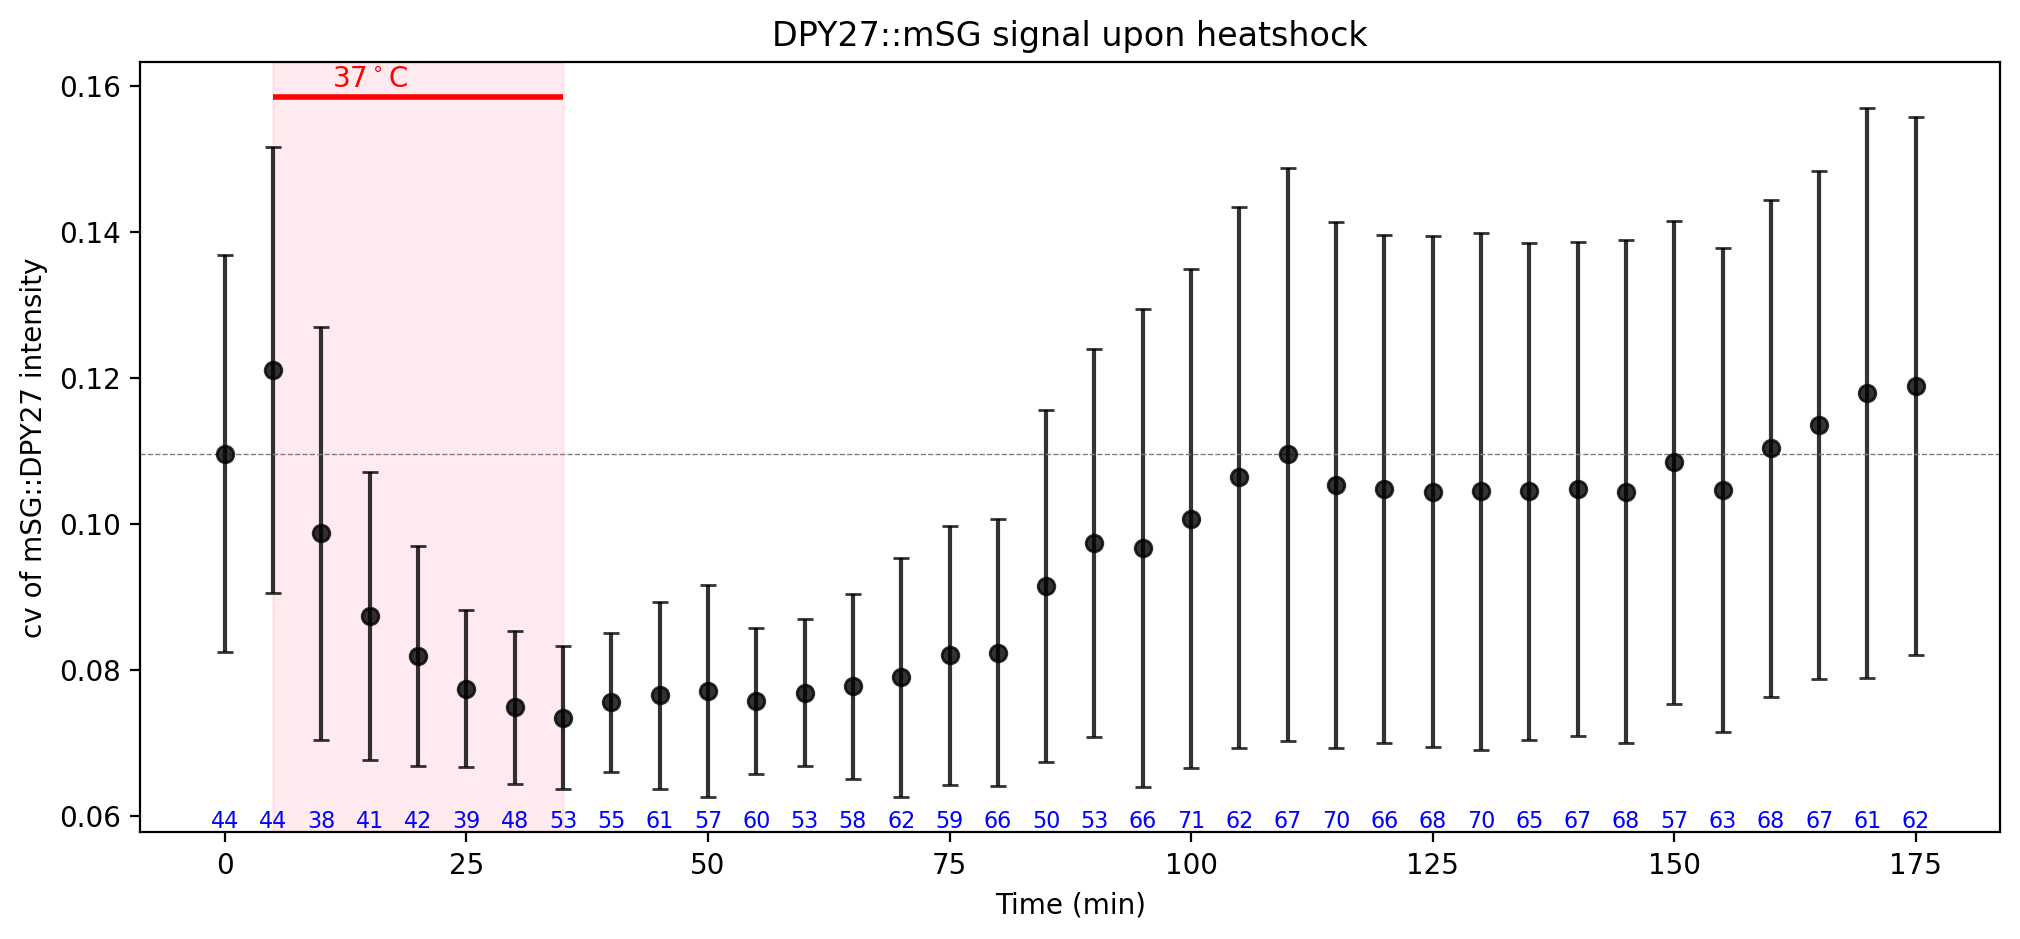

In [90]:
proteins = df.protein.unique()

for p in proteins:
    df_protein = df[df['protein'] == p]
    plot_mean_se_hs(df_protein,file_list,time_interval,output_path, metric='cv')

### Plots of total fluoresence

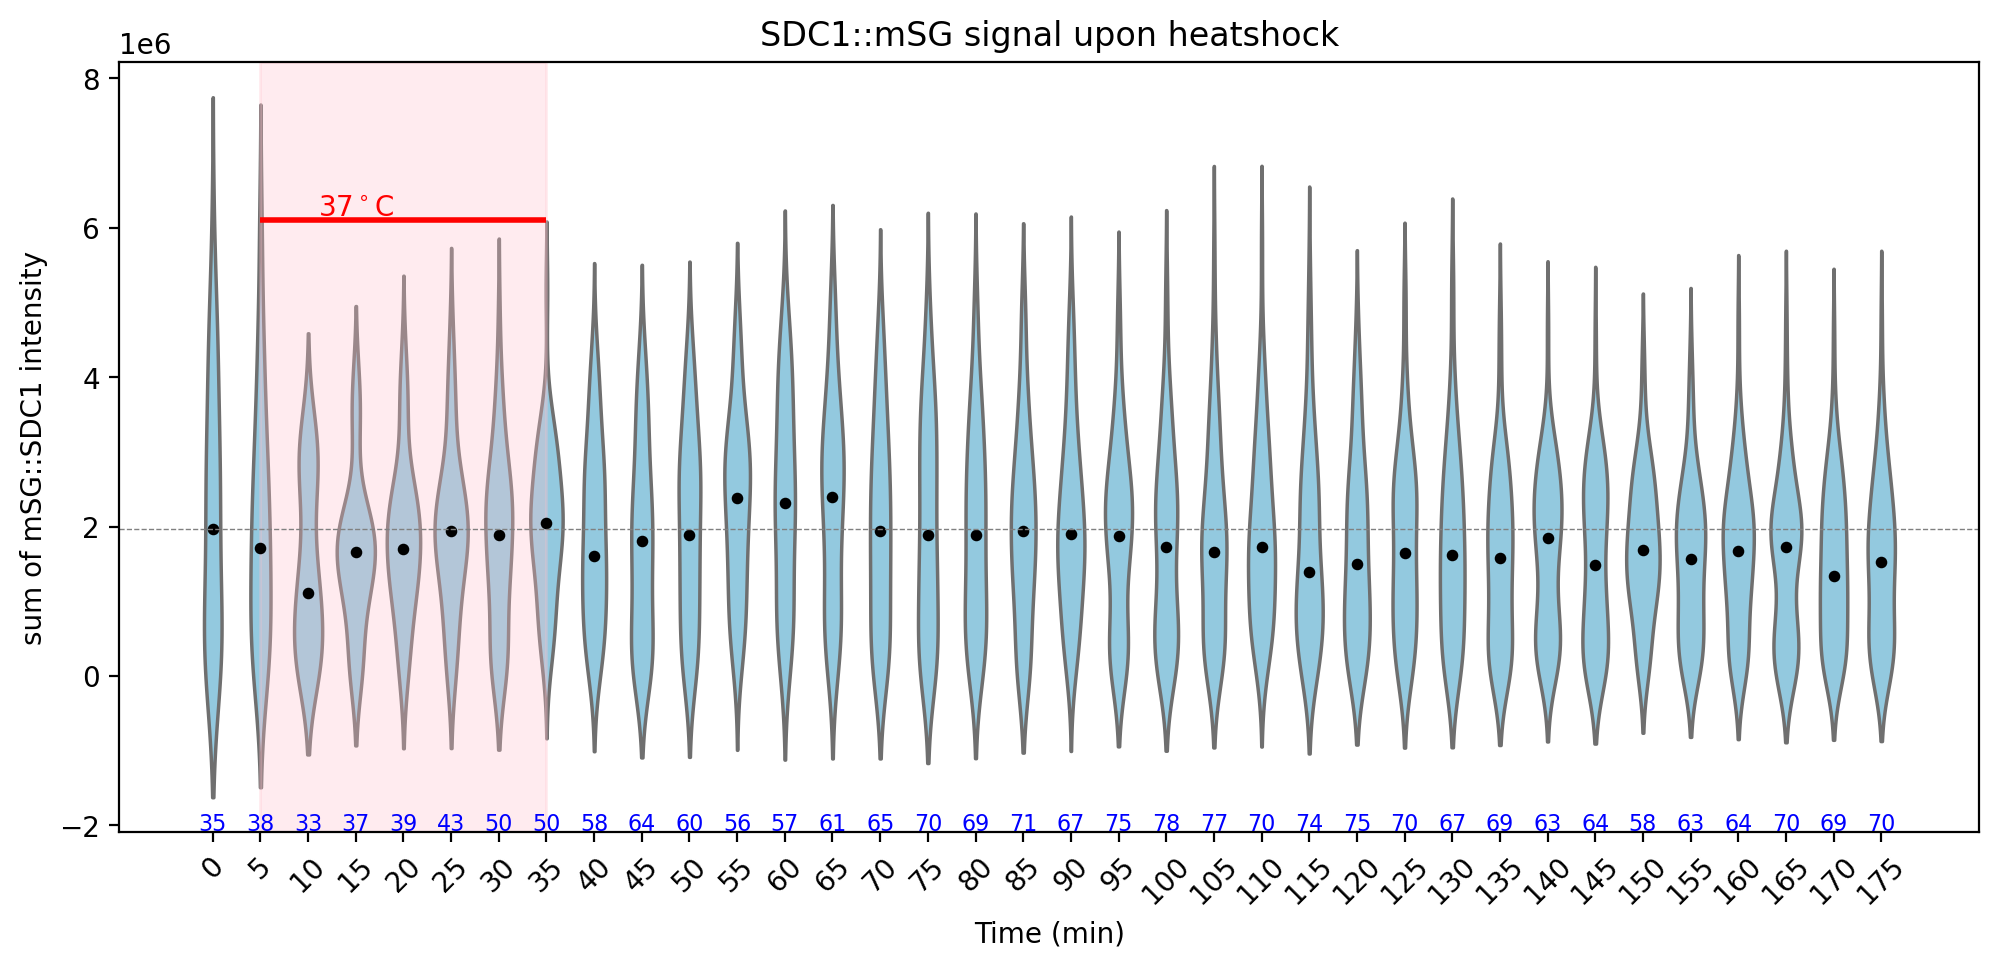

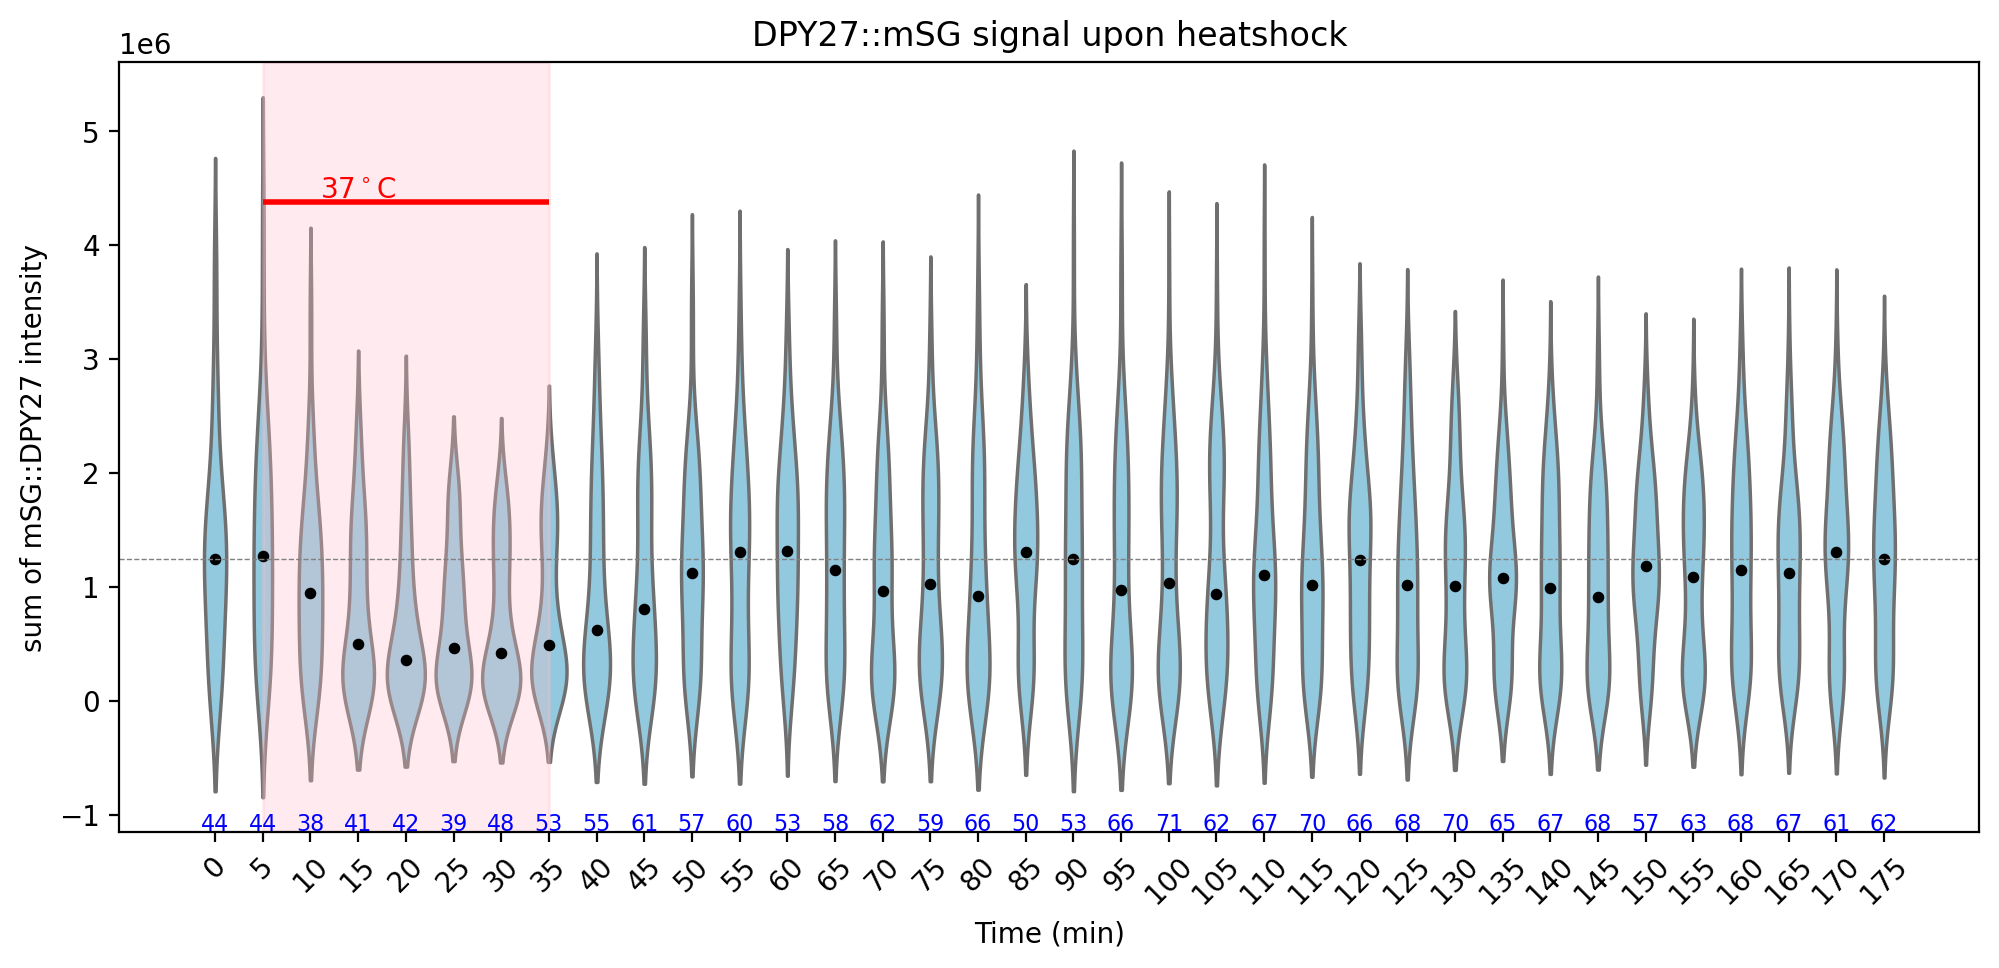

In [ ]:
proteins = df.protein.unique()

for p in proteins:
    df_protein = df[df['protein'] == p]
    plot_violin_hs(df_protein,file_list,time_interval,output_path, metric='sum')
